## Mean Reverting Arithmetic and Geometric Random Walks

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
%matplotlib inline

Read data for mean reversion and geometric mean reversion

In [2]:
xlsfile = pd.ExcelFile('http://analytics.romanko.ca/data/RandomWalks.xls')
USEuroRateData = xlsfile.parse(sheet_name='MR', header=2, parse_cols=2).iloc[0:,1]
numObsRW = len(USEuroRateData)

### Mean Reverting Arithmetic Random Walk

Create a vector of price changes

In [3]:
priceChangesMR = np.zeros((numObsRW - 1, 1))
for iObs in range(numObsRW-1):
    priceChangesMR[iObs] =  USEuroRateData[iObs + 1] - USEuroRateData[iObs]

Estimate parameters

In [4]:
X = USEuroRateData[:-1]
X = sm.add_constant(X).astype(float)
results = sm.OLS(priceChangesMR, X).fit()
beta = results.params

In [5]:
beta

const    0.050041
Close   -0.034742
dtype: float64

In [6]:
interceptMR = beta[0]
slopeMR = beta[1]
if (slopeMR > 0):
    raise ValueError('Cannot use mean reversion: slope positive')

In [7]:
sigmaMR = np.std(results.resid) # standard deviation of errors in the regression
kappaMR = -slopeMR
muMR = -interceptMR/slopeMR

Convert the estimated drift and volatility to annual values since the data for estimation were weekly, multiply by 52 (weeks in a year)

In [8]:
muMR = muMR * 52
sigmaMR = sigmaMR * np.sqrt(52)

Define function `MRPaths` that computes random paths for mean reverting random walk

In [9]:
def MRPaths(initPrice, mu, sigma, speed, T, numSteps, numPaths):
    """
    Computes numPaths random paths for mean reversion process
    
    Args:
        mu is the annual drift, sigma the annual volatility
        speed is the speed of adjustment (kappa)
        T is the total length of time for the path (in years)
        dT is the time increment (in years)

    Returns:
        random paths for an mean reverting arithmetic random walk
    """
    paths = np.zeros((numSteps + 1, numPaths))
    
    # dT is the time increment (in years)
    dT = T / numSteps
    
    # Vector of paths will store realizations of the asset price
    # First asset price is the initial price
    paths[0] = [initPrice] * numPaths
 
    # Generate paths
    for iPath in range(numPaths):
        for iStep in range(numSteps):
            paths[iStep + 1, iPath] = paths[iStep, iPath] + speed*(mu*dT - paths[iStep, iPath]) + sigma*np.sqrt(dT)*np.random.normal(0,1)
                   
    # Plot paths
    [plt.plot(paths[:,i], linewidth=2) for i in range(numPaths)]
    plt.title('Mean Reversion Paths')
    return paths

Simulate paths for the mean reverting walk

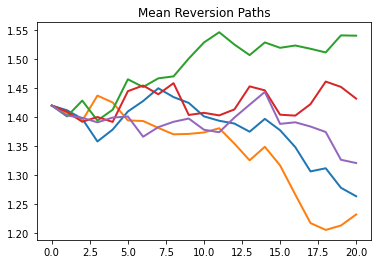

In [10]:
MRPaths(USEuroRateData[numObsRW-1], muMR, sigmaMR, kappaMR, 20.0/52, 20, 5);

### Geometric Mean Reversion Random Walk

Create a vector of percentage changes

In [11]:
percentageChangesGMR = np.zeros((numObsRW - 1,1))
for iObs in range(numObsRW - 1):
    percentageChangesGMR[iObs] = (USEuroRateData[iObs + 1] - USEuroRateData[iObs]) / USEuroRateData[iObs]

Estimate parameters

In [12]:
resultsGMR = sm.OLS(percentageChangesGMR, X).fit()
betaGMR = results.params

In [13]:
interceptGMR = betaGMR[0]
slopeGMR = betaGMR[1]
if (slopeGMR > 0):
    raise ValueError('Cannot use geometric mean reversion: slope positive')

In [14]:
sigmaGMR = np.std(resultsGMR.resid) # standard deviation of errors in the regression
kappaGMR = -slopeGMR
muGMR = -interceptGMR/slopeGMR

Convert the estimated drift and volatility to annual values since the data for estimation were weekly, multiply by 52 (weeks in a year)


In [15]:
muGMR = muGMR * 52
sigmaGMR = sigmaGMR * np.sqrt(52)

Define function `GMRPaths` that computes random paths for geometric mean reverting random walk

In [16]:
def GMRPaths(initPrice, mu, sigma, speed, T, numSteps, numPaths):
    """
    Computes numPaths random paths for geometric mean reversion process
    
    Args:
        mu is the annual drift, sigma the annual volatility
        speed is the speed of adjustment (kappa)
        T is the total length of time for the path (in years)
        dT is the time increment (in years)

    Returns:
        random paths for geometric mean reverting random walk
    """
    paths = np.zeros((numSteps + 1, numPaths))
    
    # dT is the time increment (in years)
    dT = T / numSteps
    
    # Vector of paths will store realizations of the asset price
    # First asset price is the initial price
    paths[0] = [initPrice] * numPaths
 
    # Generate paths
    for iPath in range(numPaths):
        for iStep in range(numSteps):
            paths[iStep + 1, iPath] = paths[iStep, iPath] + speed*(mu*dT - paths[iStep, iPath])*paths[iStep, iPath] + sigma*paths[iStep, iPath]*np.sqrt(dT)*np.random.normal(0,1)
            
    # Plot paths
    [plt.plot(paths[:,i], linewidth=2) for i in range(numPaths)]
    plt.title('Geometric Mean Reversion Paths')
    return paths

Simulate paths for geometric mean reverting walk

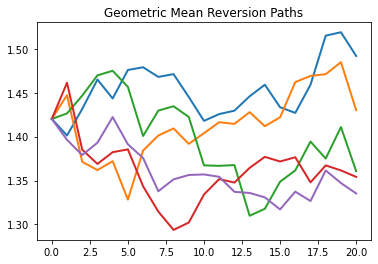

In [17]:
GMRPaths(USEuroRateData[numObsRW - 1], muGMR, sigmaGMR, kappaGMR, 20.0/52, 20, 5);